In [1]:
# Updated Qiskit imports for version 1.0
import qiskit
import qiskit_aer
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.circuit.library import Initialize, SwapGate, RYGate, HamiltonianGate, QFT
from qiskit.quantum_info import Operator
import numpy as np
from numpy import linalg as LA
from copy import deepcopy
from numpy import matmul
import math

# Matplotlib inline to visualize plots
%matplotlib inline

print("Qiskit version:", qiskit.__version__)
print("Qiskit Aer version:", qiskit_aer.__version__)

Qiskit version: 1.1.1
Qiskit Aer version: 0.14.2


# HHL Circuit

In [2]:
# HHL QLSA Solver
def quantum_linear_solver(A, b, t0=2*np.pi, shots=10000):
    """
    A: The matrix representing the linear system.
    b: The vector representing the right-hand side of the linear system.
    t: A time parameter used in the controlled-Hamiltonian operations.
    r: A parameter used to determine the rotation angles for the ancilla qubit.
    shots: The number of shots (repetitions) for the quantum circuit execution.
    """
    #==========================================================================
    # Preprocessing
    #==========================================================================

    # Check the hermitian matrix
    def check_hermitian(mat):
        assert np.allclose(mat, mat.T.conjugate(), rtol=1e-05, atol=1e-08), \
        "Sorry! The input matrix should be Hermitian."
    check_hermitian(A)

    # Normalize A and b
    norm_b = LA.norm(b)
    A = A / norm_b
    b = b / norm_b

    # Calculate condition number and eigenvalues of A
    kappa = LA.cond(A)
    eigs = LA.eigvals(A)

    # finding max and min eigs
    eigs.sort()
    lam_max = eigs[-1]
    lam_min = eigs[0]

    # estimating l and m parameters for the general circuit
    if lam_min > 2:
        l = math.ceil(math.log2(lam_min))
    else:
        l = 1 #for the negative case, set l to 1
    print("l:",l)
    m = math.ceil(math.log2(lam_max))
    print("m:", m)
    t = len(eigs)
    print("t:",t)

    # checking if m-l ~ log(kappa)
    print("log(kappa):",math.log2(kappa), "m-l:",m-l)

    #==========================================================================
    # Quantum Circuit
    #==========================================================================

    # Qubit registers
    ancilla_qbit    = QuantumRegister(1,name='anc')
    l_reg           = QuantumRegister(l,name='l')
    m_reg           = QuantumRegister(m,name='m')
    c_reg           = QuantumRegister(t,name='c') #t in the algorithm is found by Group Leader Optimization Algorithm ?
    b_reg           = QuantumRegister(math.log2(len(b)),name='b')
    ancilla_result  = ClassicalRegister(1,name='anc_result')
    b_vec           = ClassicalRegister(math.log2(len(b)),name='b_vec')
    num_qubits = l+m+t+2

    # Define empty circuit
    circ = QuantumCircuit(ancilla_qbit, l_reg, m_reg, c_reg, b_reg, ancilla_result, b_vec)

    # Encode vector b
    init = Initialize(list(b))
    circ.append(init,b_reg)

    #===========================================================================
    circ.barrier()
    # Hadamard
    circ.h(l_reg)
    circ.h(m_reg)
    circ.h(c_reg)

    #================================================================================================
    circ.barrier()
    #Rzz gate on L and M registers
    k = 0
    while k < m:
        circ.rzz(t/(2**(m-k)), m_reg[k], l_reg[l-1])
        k+=1

    #================================================================================================
    circ.barrier()
    # Apply controlled-Hamiltonian operators on register b
    for i in range(t):
        time = t0/(2**(t-i))
        U = HamiltonianGate(A, time)
        G = U.control(1)
        qubit = [l+m+i+1]+[l+m+t+j+1 for j in range(int(math.log2(len(b))))]
        circ.append(G,qubit)
        #circ.G(c_reg[i], b_reg[0]) #might need to use .append instead of circ.G to this doesn't work
        #Ramin's code: qubit = [i+1]+[c_num+j+1 for j in range(b_num)]
                      #circ.append(G,qubit)

    #================================================================================================
    circ.barrier()
    #IQFT
    iqft = QFT(t,approximation_degree=0, do_swaps=True, inverse=True, name='IQFT')
    circ.append(iqft,c_reg)

    #================================================================================================
    circ.barrier()
    #Hamiltonian Simulation (Fig.6)
    for k_l in range(l): #iterates G(l) to G(1)
        for k_m in range(m): #applies Rz to M register
            k_t = 1
            time = t0/(2**(t-k_t+1+l-k_l+k_m)) # do not add +1 to k_l to start from G(l)
            circ.rz(time, m_reg[k_m])
            k_t += 1
    
    #================================================================================================
    circ.barrier()
    #Swap
    circ.append(SwapGate(),[c_reg[1], c_reg[t-1]])

    #================================================================================================
    circ.barrier()
    #ancilla rotation
    for k_l in range(l):
      theta = (2**k_l)/eigs[k_l] #check lamda calculation
      U = RYGate(theta).control(1)
      circ.append(U,[k_l+1,0])

    # Measure ancilla qubit
    circ.measure(ancilla_qbit, ancilla_result)

    #================================================================================================
    #  Uncompute
    #================================================================================================
    circ.barrier()
    #Swap
    circ.append(SwapGate(),[c_reg[1], c_reg[t-1]])

    #================================================================================================
    circ.barrier()
    # Inverse Hamiltonian Simulation
    for k_l in range(l): #iterates G(l) to G(1)
        for k_m in range(m): #applies Rz to M register
            k_t = 1
            time = t0/(2**(t-k_t+1+l-k_l+k_m))
            circ.rz(-time, m_reg[k_m])
            k_t += 1

    #================================================================================================
    circ.barrier()
    #QFT
    qft = QFT(t,approximation_degree=0, do_swaps=True, inverse=False, name='QFT')
    circ.append(qft,c_reg)

    #================================================================================================
    circ.barrier()
    # Inverse controlled-Hamiltonian operators on register b
    for i in range(t)[::-1]:
        time = t0/(2**(t-i))
        U = HamiltonianGate(A, -time)
        G = U.control(1)
        qubit = [l+m+i+1]+[l+m+t+j+1 for j in range(int(math.log2(len(b))))]
        circ.append(G,qubit)

    #================================================================================================
    circ.barrier()
    #Rzz gate on L and M registers
    k = 0
    while k < m:
        circ.rzz(t/(2**(m-k)), m_reg[k], l_reg[l-1])
        k+=1

    #================================================================================================
    circ.barrier()
    # Hadamards
    circ.h(l_reg)
    circ.h(m_reg)
    circ.h(c_reg)

    #================================================================================================
    circ.barrier()
    # Measure b
    circ.measure(b_reg, b_vec)

    #================================================================================================
    # Execute the quantum circuit
    #================================================================================================

    # Transpile and run the circuit using AerSimulator
    aer_sim = AerSimulator()
    new_circuit = transpile(circ, aer_sim)
    job = aer_sim.run(new_circuit, shots=shots)
    result = job.result()
    
    return result, circ

# Classical Readout

In [3]:
# Extract approximate solution of the quantum linear solver
def approximate_quantum_sol(result,b):
    b_num = int(math.log2(len(b)))
    num = 0
    app_sol = np.zeros(2**(b_num))

    for key, value in result.items(): 
        if key[-1] == '1':
            num += value 
            cord = int(key[:b_num],base=2)
            app_sol[cord] = value
    
    app_sol = 1/num *app_sol
    return app_sol

# Run the Circuit!

In [4]:
# Define linear system

A = np.array([[0, 1, 1, 0], 
              [1, -1, 0, 0], 
              [1, 0, -.5, 0], 
              [0,0,0,1]])

b = np.array([0, 0, -.5, 0])

# Normalize
norm_b = LA.norm(b)
A = A / norm_b
b = b / norm_b

# Exact solution 
csol = LA.solve(A,b)
print("A:", A)
print()
print("b:", b)
print()
print("solution x:", csol)

A: [[ 0.  2.  2.  0.]
 [ 2. -2.  0.  0.]
 [ 2.  0. -1.  0.]
 [ 0.  0.  0.  2.]]

b: [ 0.  0. -1.  0.]

solution x: [-0.33333333 -0.33333333  0.33333333  0.        ]


In [5]:
result, circuit = quantum_linear_solver(A, b)
counts = result.get_counts()

# Extract approximate solution
qsol = approximate_quantum_sol(counts,b)

l: 1
m: 2
t: 4
log(kappa): 1.3646456793300976 m-l: 1


============================== Final results ==============================

Exact solution =  [-0.33333333 -0.33333333  0.33333333  0.        ]
Quantum solver solution =  [0. 0. 1. 0.]
Norm of difference =  0.816496580927726 

Figure(800x600)


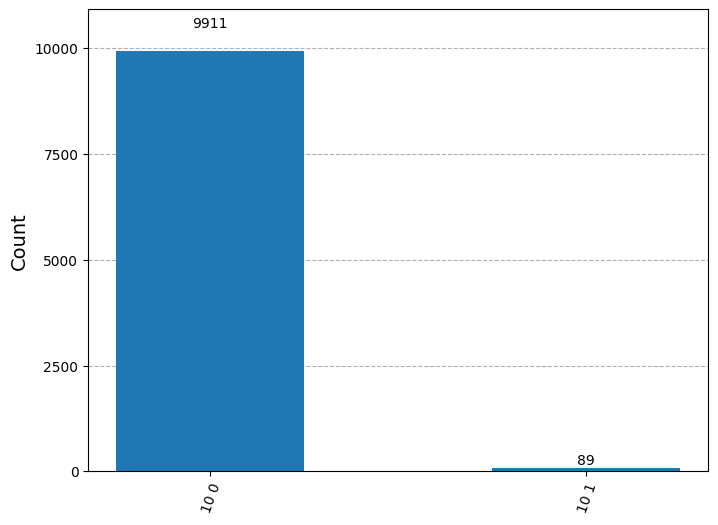

In [6]:
print("============================== Final results ==============================\n")
print ('Exact solution = ', csol)
print('Quantum solver solution = ', qsol)
print('Norm of difference = ', LA.norm(qsol- csol),'\n')

print(plot_histogram(counts,figsize = (8,6),bar_labels = True))

Figure(2322.93x3210.67)


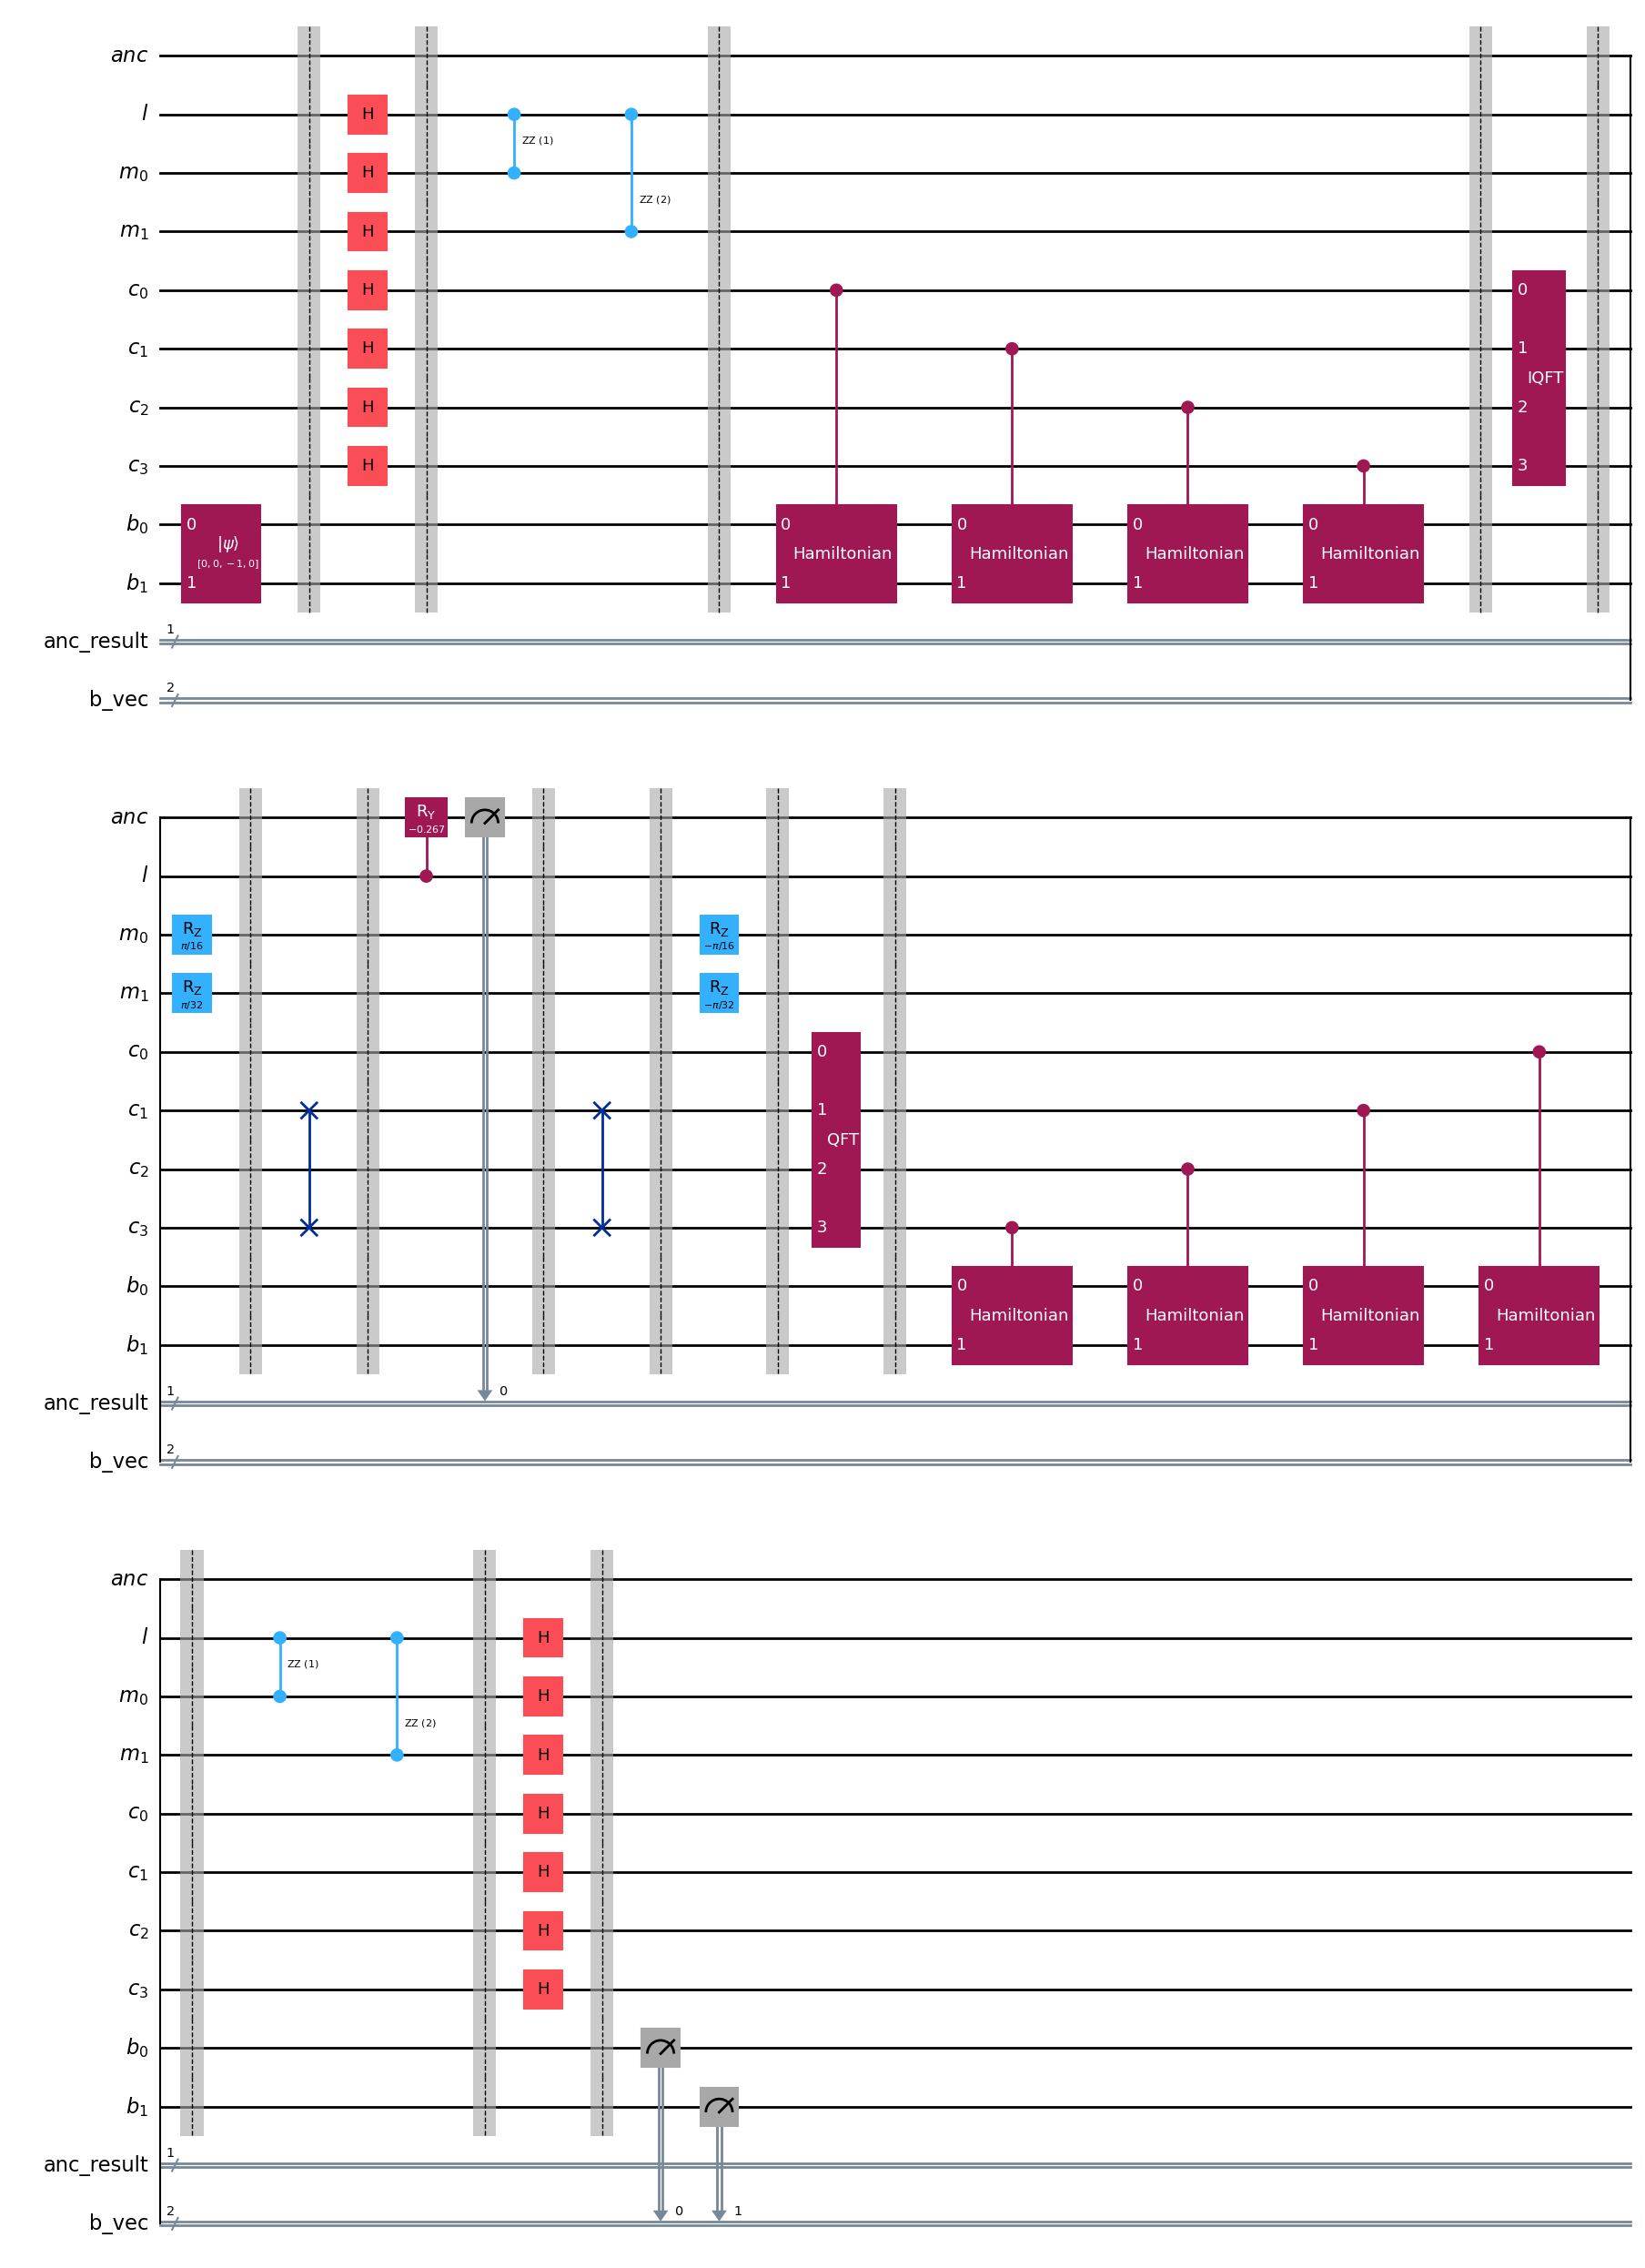

In [7]:
print(circuit.draw(output='mpl'))